In [2]:
# do not run if you have dataset somewhere
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayaroshevskiy/downsampled-imagenet-64x64")
print("Path to dataset files:", path)

/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/igor.varha/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1


Imports

In [21]:
from image_toolkit.nets import TransformerPatchCluster
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from image_toolkit.data_processor import FragmentDataset
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.pyplot as plt


In [22]:

# here please insert path with images you are using
test_path = Path(path)/'valid_64x64/valid_64x64'


In [31]:

# here please use limit if you to limit amount of images you are using
test_dataset = FragmentDataset(test_path,limit=1000, augment=False)
dataloader_test = DataLoader(test_dataset, batch_size=10, shuffle=True)

  2%|▏         | 999/49999 [00:00<00:28, 1705.00it/s]


In [32]:
# loading of a model
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = TransformerPatchCluster(embed_dim=256,nhead=8,device=DEVICE,num_layers=7).to(DEVICE) #0.72
model.load_weights("best_TTC_256_8_8_ARI90(100K)/best_model_epoch_78.pth")
model.eval()

Weights loaded from best_TTC_256_8_8_ARI90(100K)/best_model_epoch_78.pth


/Users/igor.varha/PycharmProjects/samp_hum_home/image_toolkit/nets.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location=s

TransformerPatchCluster(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Cluster loaded images and visualise results

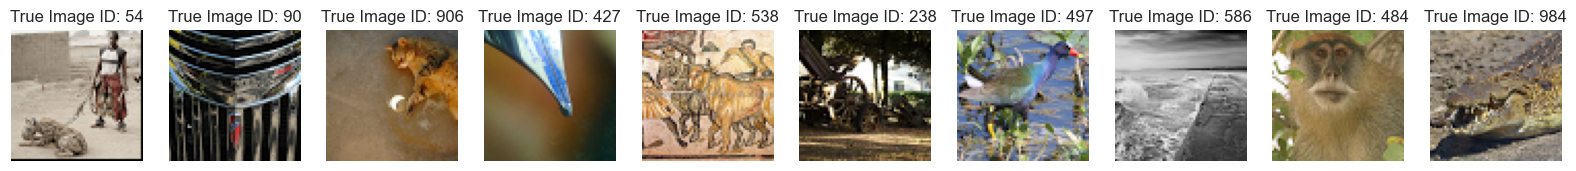

In [44]:
#cluster 1 batch and plot it
batch,labels = next(iter(dataloader_test))
all_images = [ test_dataset.get_full_image(idx) for idx in labels]
B, N, C, H, W = batch.shape
true_labels = labels.numpy().repeat(N)
batch = batch.view(B * N, C, H, W)
# shuffle the batch by first dimension
idx = torch.randperm(batch.size(0))
batch = batch[idx]
true_labels = true_labels[idx]
embeddings = model(batch.to(DEVICE))
embeddings = embeddings.cpu().detach().numpy()
cluster = AgglomerativeClustering(n_clusters=B).fit_predict(embeddings)
# plot all images
fig, ax = plt.subplots(1, len(all_images), figsize=(20, 20))
for i, image in enumerate(all_images):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis('off')
    ax[i].set_title(f"True Image ID: {labels[i]}")
plt.show()

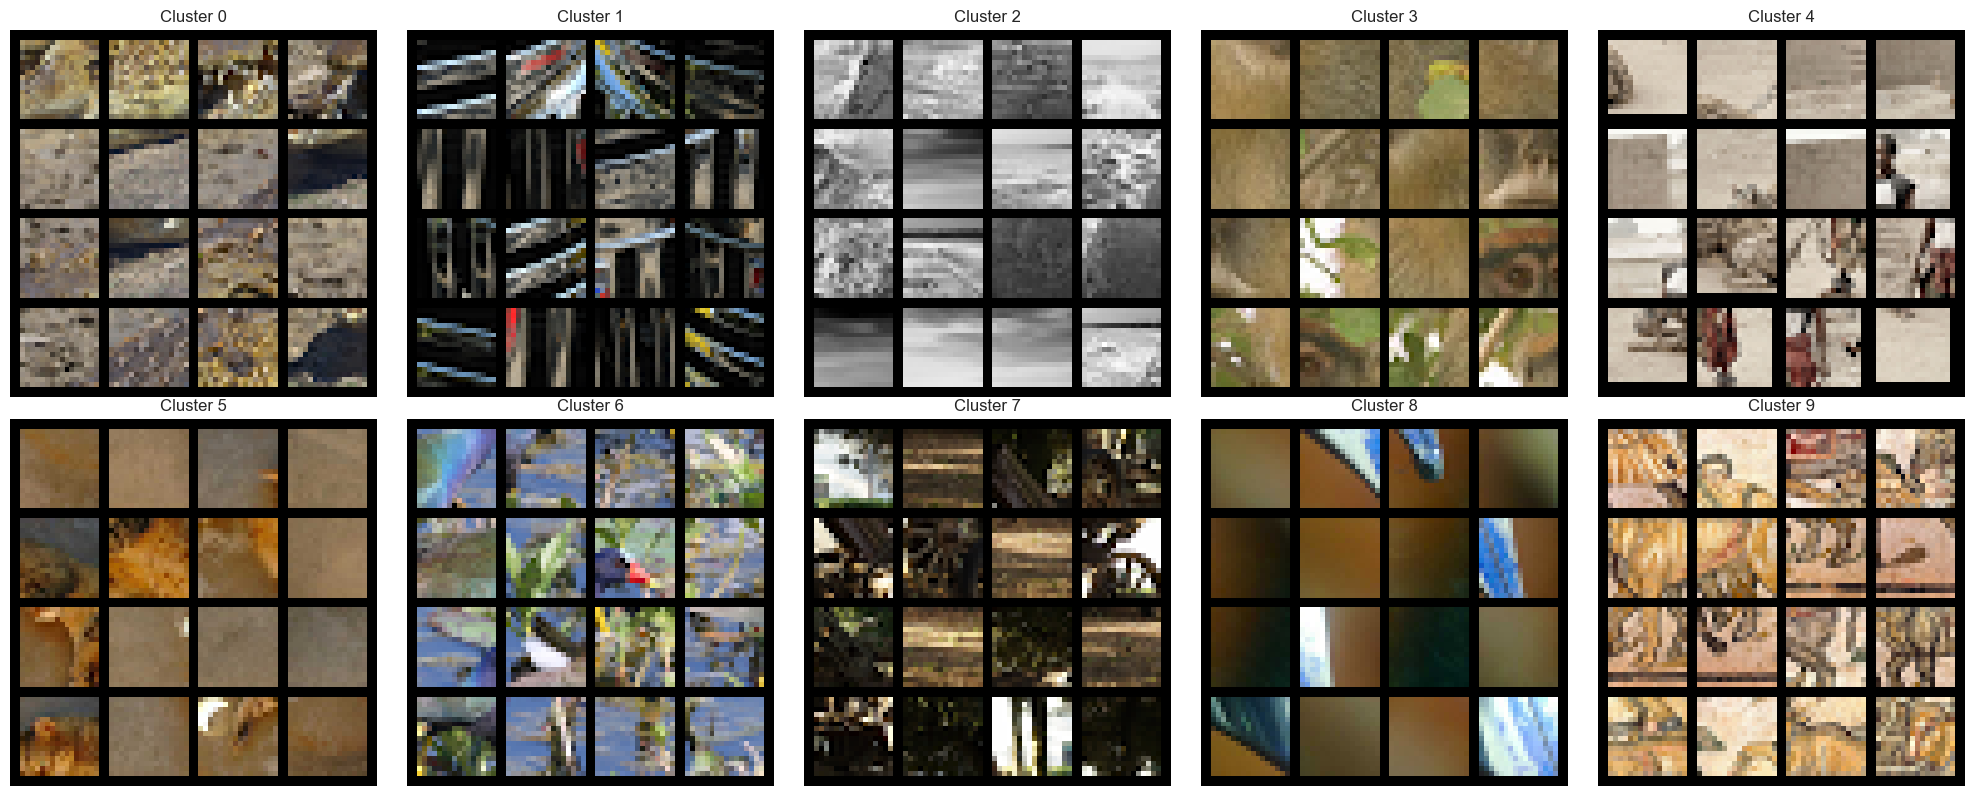

In [45]:
# Create B//5 rows, 5 columns
fig, axs = plt.subplots(B//5+1 if B%5>0 else B//5, 5, figsize=(20, 8))
axs = axs.flatten()  # Flatten to index easily
for cluster_id in range(B):
    indices = [i for i, c in enumerate(cluster) if c == cluster_id]
    if not indices:
        axs[cluster_id].axis('off')
        continue
    clustered_patches = batch[indices].cpu()
    grid = vutils.make_grid(clustered_patches, nrow=4, padding=2, normalize=True)
    axs[cluster_id].imshow(grid.permute(1, 2, 0))
    axs[cluster_id].axis('off')
    axs[cluster_id].set_title(f"Cluster {cluster_id}")
plt.tight_layout()
plt.show()

Here is debug plot to see how model displaced features.

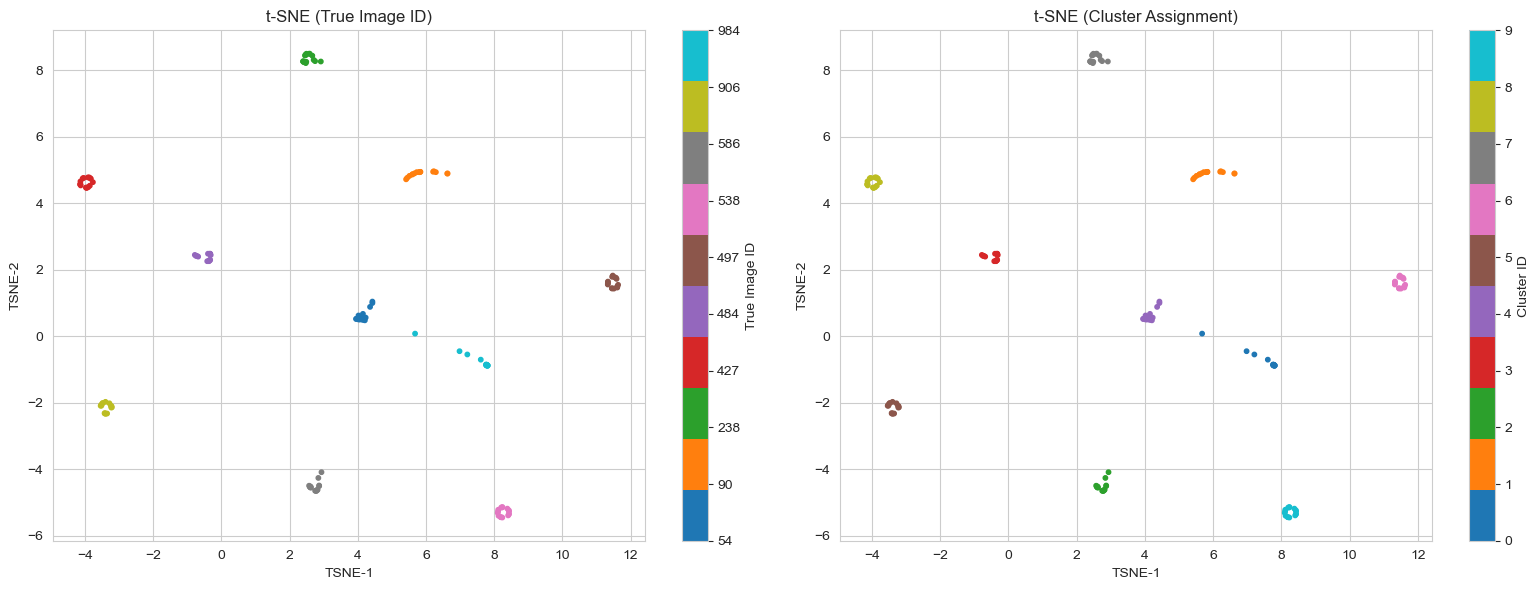

In [46]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

unique_labels = np.unique(true_labels)
n_classes = len(unique_labels)

# Map true_labels to 0...n_classes-1
label_map = {label: i for i, label in enumerate(unique_labels)}
label_ids = np.array([label_map[l] for l in true_labels])

# Create colormap
base_cmap = plt.colormaps.get_cmap('tab10')  # continuous colormap
cmap = ListedColormap(base_cmap(np.linspace(0, 1, n_classes)))  # discrete colormap

# Create the combined figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Ground Truth Labels
scatter1 = axs[0].scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_ids, cmap=cmap, s=B)
cbar1 = fig.colorbar(scatter1, ax=axs[0], ticks=np.arange(n_classes))
cbar1.ax.set_yticklabels(unique_labels)
cbar1.set_label("True Image ID")
axs[0].set_title("t-SNE (True Image ID)")
axs[0].set_xlabel("TSNE-1")
axs[0].set_ylabel("TSNE-2")

# Plot 2: Clustering Results
scatter2 = axs[1].scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster, cmap='tab10', s=B)
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label("Cluster ID")
axs[1].set_title("t-SNE (Cluster Assignment)")
axs[1].set_xlabel("TSNE-1")
axs[1].set_ylabel("TSNE-2")

plt.tight_layout()
plt.show()